<a href="https://colab.research.google.com/github/Weff24/PrivacyPlate/blob/main/pp_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Notebook Setups

## 1.1 Install Environment Requirements

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install -U yolov5

In [2]:
import cv2
import pytesseract
import yolov5

pytesseract.pytesseract.tesseract_cmd = ( r'/usr/bin/tesseract' )

In [7]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import xml.etree.ElementTree as ET
import os
import sys
from collections import defaultdict

from pathlib import Path
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

## 1.2 Setup Methods

In [9]:
### Extraction Method ###
def extract_license_plate_text(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding or other preprocessing techniques if needed
    # Example: gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Use Tesseract OCR to extract text
    text = pytesseract.image_to_string(gray, config='--psm 7 --oem 1')

    return text

### Loading Model For Yolo ###
def load_model_bounding():
  model = yolov5.load('keremberke/yolov5m-license-plate')

  # set model parameters
  model.conf = 0.5  # NMS confidence threshold
  model.iou = 0.45  # NMS IoU threshold
  model.agnostic = False  # NMS class-agnostic
  model.multi_label = False  # NMS multiple labels per box
  model.max_det = 1000  # maximum number of detections per image

  return model

### Show Bounding Boxes Using Yolo ###
def bounding_box_show(image_path, model):
  # perform inference
  results = model(image_path, size=640)

  # inference with test time augmentation
  results = model(image_path, augment=True)

  # parse results
  predictions = results.pred[0]
  boxes = predictions[:, :4] # x1, y1, x2, y2
  scores = predictions[:, 4]
  categories = predictions[:, 5]

  # show detection bounding boxes on image
  results.show()

# 2. Image Blurring

In [10]:
# Round up to nearest odd integer for Gaussian Blur kernel size
def to_nearest_odd(n):
    if n % 2 == 0:
        return n + 1
    return n

In [11]:
# Path to annotation folder
annot_dir_path = Path("/content/drive/MyDrive/01-License Plates/annotations")

if not annot_dir_path.exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# Extract the box from xml files
box_locations = defaultdict(list)
box_sizes = defaultdict(list)
box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location
box_size_elements = ['width', 'height'] # order of image size

for path in os.listdir(annot_dir_path):
    tree = ET.parse(f'{annot_dir_path}/{path}')  # Replace 'your_xml_file.xml' with your XML file path
    root = tree.getroot()

    # Get key from XML
    xml_ind =int(path[4:-4])

    for element in box_elements:
        box_locations[xml_ind].append(int(root.find('object').find('bndbox').find(element).text))

    for element in box_size_elements:
        box_sizes[xml_ind].append(int(root.find('size').find(element).text))

# Check dimensions of images
max_w = 0
max_h = 0
for w, h in box_sizes.values():
    if max_w < w:
        max_w = w
    if max_h < h:
        max_h = h

print('Max Width = ', max_w)
print('Max Height = ', max_h)

Max Width =  600
Max Height =  531


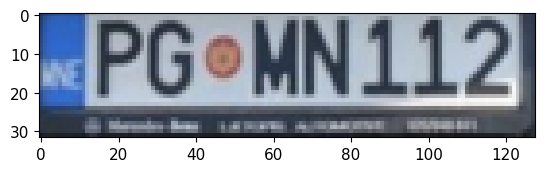

In [12]:
%matplotlib inline

img_dir_path = Path("/content/drive/MyDrive/01-License Plates/paddedimages")

if not img_dir_path.exists():
  print("Image directory path does not exist")
  sys.exit(1)

cropped_plate_images = []
plate_images = []

i = 0
for i, path in enumerate(os.listdir(img_dir_path)):
  plate_image = mpimg.imread(f"{img_dir_path}/{path}")
  fig, ax = plt.subplots()

  box = box_locations[int(path[4:-4])]
  cropped_plate_image = plate_image[box[1]:box[3], box[0]:box[2]]

  ax.imshow(cropped_plate_image)
#   plt.axis("off")
#   plt.savefig("/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar.png")
  plt.show()

  plate_images.append((plate_image, box))
  cropped_plate_images.append((cropped_plate_image, box))

  i += 1
  if i == 1:
    break

plt.close()

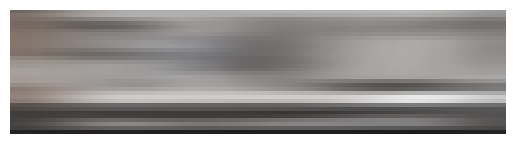

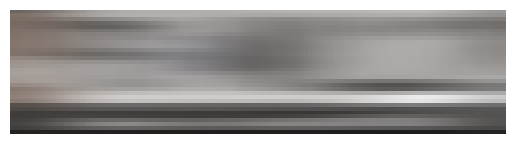

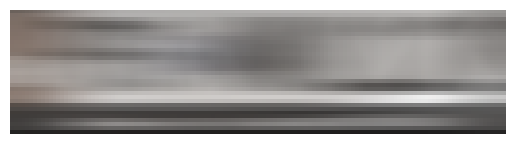

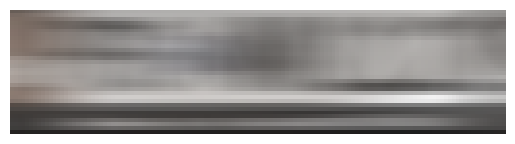

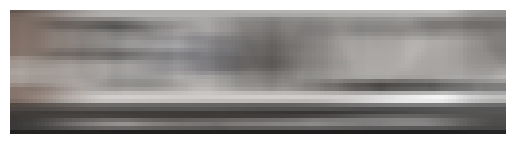

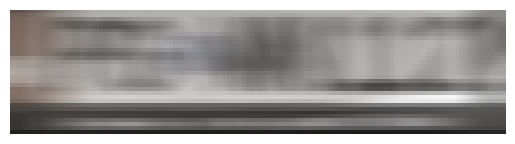

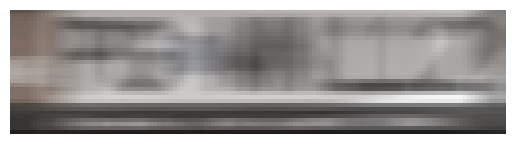

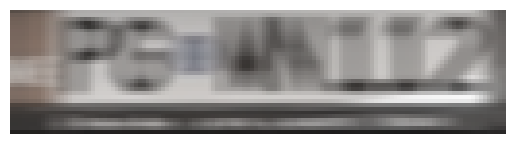

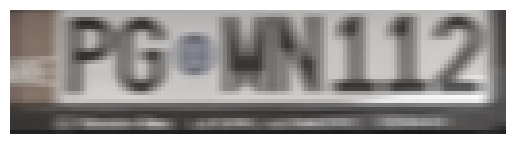

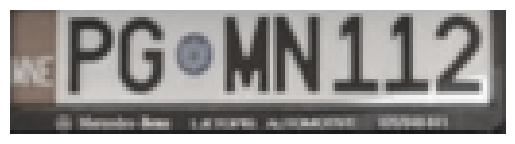

In [16]:
final_images = [0] * (3 * len(plate_images))
num_blur_levels = 10

for i in range(len(cropped_plate_images)):
    for blur_level in range(0, num_blur_levels):
        # Blur plate image
        cropped_plate_image = cropped_plate_images[i][0]
        cropped_plate_image_tensor = torch.from_numpy(cropped_plate_image)

        kernel_size = [5, to_nearest_odd((cropped_plate_image_tensor.size()[1] - cropped_plate_image_tensor.size()[1] * (blur_level) // (num_blur_levels - 1)) // 3)]
        sigma = 10
        blurred_plate_image = transforms.functional.gaussian_blur(cropped_plate_image_tensor, kernel_size, sigma).numpy()

        # Save cropped and blurred image
        fig, ax = plt.subplots()
        plt.axis("off")
        ax.imshow(blurred_plate_image)
        plt.savefig(f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{blur_level}.png")

        # Place blurred plate back into full image
        box = plate_images[i][1]
        final_image = plate_images[i][0].copy()
        final_image[box[1]:box[3], box[0]:box[2]] = blurred_plate_image
        final_images[i] = final_image

        # Show final blurred images
        # fig, ax = plt.subplots()
        # plt.axis("off")
        # ax.imshow(final_image)

        # plt.savefig(f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{blur_level}.png")

# 3. Pipeline Evaluation

In [21]:
bounding_box_model = load_model_bounding()

for blur_level in reversed(range(0, num_blur_levels)):
    img_path = f"/content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar{blur_level}.png"
    extracted_text = extract_license_plate_text(img_path)

    # 1. Extracted text first
    if len(extracted_text) != 0:
        print(f"Extracted text from - {img_path}: {extracted_text}")
        continue

    # 2. Run YOLO model to show bounding box if the extracted text is empty
    bounding_box_show(img_path, bounding_box_model)

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar9.png: EPGeMN112]

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar8.png: pPosam112

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar7.png: pom

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar6.png: 
Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar5.png: a

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar4.png: ae

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar3.png: aa 2

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar2.png: as

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar1.png: a2

Extracted text from - /content/drive/MyDrive/01-License Plates/croppedimages/CroppedCar0.png: E

In [4]:
bounding_box_model = load_model_bounding()

while True:
    # 1. Ask for user input of the image path
    img_path = input("Please enter your desired image (q to quit)")
    if img_path == "q":
        print("Exiting...")
        break

    extracted_text = extract_license_plate_text(img_path)

    # 1. Extracted text first
    if len(extracted_text) != 0:
        print(f"Extracted text from - {img_path}: {extracted_text}")
        continue

    # 2. Run YOLO model to show bounding box if the extracted text is empty
    bounding_box_show(img_path, bounding_box_model)



config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

KeyboardInterrupt: ignored